# Building Graph Neural Networks

In [1]:
%pip install rdkit
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch torchvision torchaudio
%pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pickle
import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import numpy as np
from rdkit import Chem
from torch_geometric.utils import from_smiles
import pandas as pd
from sklearn.metrics import roc_auc_score
from IPython.display import HTML, display

CONFIG = {
    'data_dir': './processed_tox21',
    'hidden_channels': 128,
    'num_layers': 3,
    'dropout': 0.2,
    'batch_size': 64,
    'lr': 1e-3,
    'weight_decay': 0,
    'epochs': 50,
    'patience': 8,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Automatically detects if you have a GPU
print(f"Using device: {CONFIG['device']}")


/home/goisaiah/Visual Studio Code Projects/ToxicityPredictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Load data from preprocessing

In [4]:
def load_split(name):
    path = os.path.join(CONFIG['data_dir'], f'tox21_{name}.pkl')
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data


data_train = load_split('train')
data_validation = load_split('validation')
data_test = load_split('test')

print(f"Train: {len(data_train['smiles'])} | Validation: {len(data_validation['smiles'])} | Test: {len(data_test['smiles'])}")

Train: 6258 | Validation: 782 | Test: 783


Convert SMILES to GNNs

In [5]:
def build_graph(smi, labels):
    try:
        data = from_smiles(smi)
        labels = np.array(labels, dtype=float).reshape(-1)
        data.y = torch.tensor(labels, dtype=torch.float).unsqueeze(0)
        return data
    except Exception:
        return None


def make_dataset(smiles_list, label_matrix):
    dataset = []
    for smi, lbl in zip(smiles_list, label_matrix):
        g = build_graph(smi, lbl)
        if g is not None:
            dataset.append(g)
    
    return dataset

In [6]:
train_dataset = make_dataset(data_train['smiles'], data_train['labels'])
validation_dataset = make_dataset(data_validation['smiles'], data_validation['labels'])
test_dataset = make_dataset(data_test['smiles'], data_test['labels'])

print(f"Graphs Data")
print(f"Train: {len(train_dataset)} | Validation: {len(validation_dataset)} | Test: {len(test_dataset)}")

Graphs Data
Train: 6258 | Validation: 782 | Test: 783


In [7]:
train_loader = DataLoader(train_dataset, batch_size = CONFIG['batch_size'], shuffle = True)
val_loader = DataLoader(validation_dataset, batch_size = CONFIG['batch_size'])
test_loader = DataLoader(test_dataset, batch_size = CONFIG['batch_size'])

Double checking the dimensions of the dataset

In [8]:
# After rebuilding the dataset and re-creating train_dataset, etc.
sample = train_dataset[0]
print("single graph -- x:", sample.x.shape, "y:", sample.y.shape, "num_nodes:", sample.num_nodes)

batch = next(iter(train_loader))
print("batch.x:", batch.x.shape)
print("batch.batch:", batch.batch.shape, "max batch index:", batch.batch.max().item())
print("batch.y:", batch.y.shape)   # should be (batch_size, num_tasks)

single graph -- x: torch.Size([14, 9]) y: torch.Size([1, 12]) num_nodes: 14
batch.x: torch.Size([1115, 9])
batch.batch: torch.Size([1115]) max batch index: 63
batch.y: torch.Size([64, 12])


Class for GNN Models

In [9]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='GCN', num_layers=3, dropout=0.2):
        super().__init__()
        self.model_type = model_type
        self.convs = nn.ModuleList()
        if model_type == 'GCN':
            # Aggregates information from neighboring atoms
            self.convs.append(GCNConv(in_channels, hidden_channels))
            for _ in range(num_layers-1):
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
        elif model_type == 'GAT':
            # Learns to weight each neighbour
            self.convs.append(GATConv(in_channels, hidden_channels, heads=4, concat=False))
            for _ in range(num_layers-1):
                self.convs.append(GATConv(hidden_channels, hidden_channels, heads=4, concat=False))
        else:
            raise ValueError("model_type must be 'GCN' or 'GAT'")
        
        self.dropout = dropout
        self.lin = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels//2, out_channels)
        )

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        return self.lin(x)
    
    def forward_with_attention(self, x, edge_index, batch):
        # Only returns attention weights for the first GAT layer
        if self.model_type != 'GAT':
            raise ValueError("forward_with_attention is only available for GAT models")
        
        x = x.float()
        x, (attn_edge_index, attn_values) = self.convs[0](x, edge_index, return_attention_weights=True)
        x = torch.relu(x)
        x = nn.functional.dropout(x, p=self.dropout, training=self.training)
        
        for conv in self.convs[1:]:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = nn.functional.dropout(x, p=self.dropout, training=self.training)

        x = global_mean_pool(x, batch)
        out = self.lin(x)
        return out, attn_edge_index, attn_values

Training and Evaluation Functions

In [10]:
def masked_bce_loss(logits, labels):
    """
    logits: (batch_size, num_tasks)
    labels: (batch_size, num_tasks) some NaNs
    """
    # mask indicates which label positions are valid (not NaN)
    mask = ~torch.isnan(labels)

    if mask.sum() == 0:
        return torch.tensor(0.0, device=logits.device)
    
    valid_logits = logits[mask]
    valid_labels = labels[mask]
    loss = nn.BCEWithLogitsLoss()(valid_logits, valid_labels)
    return loss

In [11]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for data in loader:
        data.x = data.x.to(torch.float)
        data.edge_index = data.edge_index.to(torch.long)
        if hasattr(data, "edge_attr") and data.edge_attr is not None:
            data.edge_attr = data.edge_attr.to(torch.float)
        data.y = data.y.to(torch.float)

        data = data.to(device)

        optimizer.zero_grad()
        logits = model(data.x, data.edge_index, data.batch)

        loss = masked_bce_loss(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [12]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in loader:
            data.x = data.x.to(torch.float)
            data.edge_index = data.edge_index.to(torch.long)
            if hasattr(data, "edge_attr") and data.edge_attr is not None:
                data.edge_attr = data.edge_attr.to(torch.float)
            data.y = data.y.to(torch.float)

            data = data.to(device)
            
            logits = model(data.x, data.edge_index, data.batch)

            if data.y.dim() == 1:
                data.y = data.y.view(-1, logits.size(1))

            loss = masked_bce_loss(logits, data.y)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

Train and Evaluate GNNs

In [13]:
sample_graph = train_dataset[0]
in_channels = sample_graph.x.shape[1]
out_channels = sample_graph.y.shape[1]
results = {}
results_rows = []
roc_rows = []

for model_type in ['GCN', 'GAT']:
    print(f"Training {model_type}")
    model = GNNModel(
        in_channels=in_channels,
        hidden_channels=CONFIG['hidden_channels'],
        out_channels=out_channels,
        model_type=model_type,
        num_layers=CONFIG['num_layers'],
        dropout=CONFIG['dropout']
    ).to(CONFIG['device'])

    optimizer = Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, CONFIG['epochs']+1):
        train_loss = train_epoch(model, train_loader, optimizer, CONFIG['device'])
        val_loss = evaluate(model, val_loader, CONFIG['device'])

        results_rows.append({
            "Model": model_type,
            "Epoch": epoch,
            "Train Loss": round(train_loss, 4),
            "Val Loss": round(val_loss, 4)
        })

        print(f"{model_type} | Epoch {epoch:03d} Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{model_type}.pt")
        else:
            patience_counter += 1
            if patience_counter >= CONFIG['patience']:
                print(f"Early stopping {model_type}")
                break
    
    model.load_state_dict(torch.load(f"best_{model_type}.pt"))
    test_loss = evaluate(model, test_loader, CONFIG['device'])
    print(f"{model_type} Test Loss: {test_loss:.4f}")

    results_rows.append({
        "Model": model_type,
        "Epoch": "Best",
        "Train Loss": None,
        "Val Loss": round(test_loss, 4),
    })

    results[model_type] = {'val_loss': best_val_loss, 'test_loss': test_loss}
    

print("Summary of training:")
print("Model | Val Loss | Test Loss")
for model_type, res in results.items():
    print(f"{model_type:4s} | {res['val_loss']:.4f} | {res['test_loss']:.4f}")

Training GCN
GCN | Epoch 001 Train Loss: 0.3059 | Val Loss: 0.2501
GCN | Epoch 002 Train Loss: 0.2529 | Val Loss: 0.2455
GCN | Epoch 003 Train Loss: 0.2470 | Val Loss: 0.2380
GCN | Epoch 004 Train Loss: 0.2431 | Val Loss: 0.2378
GCN | Epoch 005 Train Loss: 0.2403 | Val Loss: 0.2353
GCN | Epoch 006 Train Loss: 0.2394 | Val Loss: 0.2338
GCN | Epoch 007 Train Loss: 0.2360 | Val Loss: 0.2354
GCN | Epoch 008 Train Loss: 0.2346 | Val Loss: 0.2301
GCN | Epoch 009 Train Loss: 0.2344 | Val Loss: 0.2277
GCN | Epoch 010 Train Loss: 0.2322 | Val Loss: 0.2260
GCN | Epoch 011 Train Loss: 0.2314 | Val Loss: 0.2260
GCN | Epoch 012 Train Loss: 0.2322 | Val Loss: 0.2311
GCN | Epoch 013 Train Loss: 0.2298 | Val Loss: 0.2250
GCN | Epoch 014 Train Loss: 0.2316 | Val Loss: 0.2296
GCN | Epoch 015 Train Loss: 0.2303 | Val Loss: 0.2250
GCN | Epoch 016 Train Loss: 0.2276 | Val Loss: 0.2252
GCN | Epoch 017 Train Loss: 0.2284 | Val Loss: 0.2238
GCN | Epoch 018 Train Loss: 0.2293 | Val Loss: 0.2235
GCN | Epoch 019

In [14]:
def display_scrollable_df(df, height):
    html = df.to_html()
    display(HTML(
        f'<div style="max-height:{height}px; overflow-y:auto; border:1px solid #ddd; padding:10px;">{html}</div>'
    ))

In [15]:
results_df = pd.DataFrame(results_rows)
display_scrollable_df(results_df, height=500)

,Model,Epoch,Train Loss,Val Loss
0,GCN,1,0.3059,0.2501
1,GCN,2,0.2529,0.2455
2,GCN,3,0.2470,0.2380
3,GCN,4,0.2431,0.2378
4,GCN,5,0.2403,0.2353
5,GCN,6,0.2394,0.2338
6,GCN,7,0.2360,0.2354
7,GCN,8,0.2346,0.2301
8,GCN,9,0.2344,0.2277
9,GCN,10,0.2322,0.2260


AUC-ROC

In [16]:
def compute_task_auc(model, loader, device):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data.x = data.x.to(torch.float)
            data.edge_index = data.edge_index.to(torch.long)
            if hasattr(data, "edge_attr") and data.edge_attr is not None:
                data.edge_attr = data.edge_attr.to(torch.float)
            data.y = data.y.to(torch.float)

            data = data.to(device)

            logits = model(data.x, data.edge_index, data.batch)
            labels = data.y

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    logits = torch.cat(all_logits, dim=0)
    labels = torch.cat(all_labels, dim=0)

    logits = logits.numpy()
    labels = labels.numpy()

    aucs = []
    for task_idx in range(labels.shape[1]):
        valid = ~np.isnan(labels[:, task_idx])
        if valid.sum() > 0:
            aucs.append(roc_auc_score(labels[valid, task_idx], logits[valid, task_idx]))
        else:
            aucs.append(np.nan)

    return aucs


In [17]:
task_names = data_train['labels_cols']

gcn_model = GNNModel(
    in_channels=in_channels,
    hidden_channels=CONFIG['hidden_channels'],
    out_channels=out_channels,
    model_type='GCN',
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])
gcn_model.load_state_dict(torch.load("best_GCN.pt"))

gat_model = GNNModel(
    in_channels=in_channels,
    hidden_channels=CONFIG['hidden_channels'],
    out_channels=out_channels,
    model_type='GAT',
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])
gat_model.load_state_dict(torch.load("best_GAT.pt"))

gcn_auc = compute_task_auc(gcn_model, test_loader, CONFIG['device'])
gat_auc = compute_task_auc(gat_model, test_loader, CONFIG['device'])

roc_df = pd.DataFrame({
    'Task': task_names,
    'GCN AUC-ROC': gcn_auc,
    'GAT AUC-ROC': gat_auc
})

display_scrollable_df(roc_df, height=500)

,Task,GCN AUC-ROC,GAT AUC-ROC
0,NR-AR,0.776773,0.734912
1,NR-AR-LBD,0.840944,0.855321
2,NR-AhR,0.826396,0.830318
3,NR-Aromatase,0.770318,0.710930
4,NR-ER,0.664028,0.678239
5,NR-ER-LBD,0.756675,0.839150
6,NR-PPAR-gamma,0.758687,0.823189
7,SR-ARE,0.706318,0.711635
8,SR-ATAD5,0.752349,0.776105
9,SR-HSE,0.707559,0.757627


In [18]:
batch = next(iter(test_loader))
print("x:", batch.x.shape)
print("y:", batch.y.shape)
print("batch:", batch.batch.shape)


x: torch.Size([1173, 9])
y: torch.Size([64, 12])
batch: torch.Size([1173])


# GCN vs GAT

In [19]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


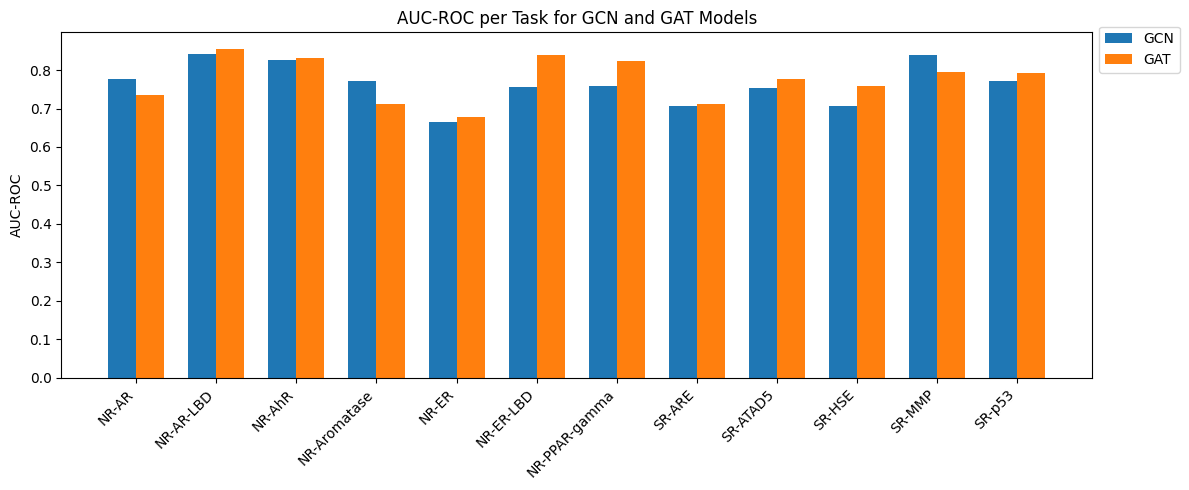

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,5))
x = np.arange(len(roc_df))
width = 0.35
plt.bar(x - width/2, roc_df['GCN AUC-ROC'], width, label='GCN')
plt.bar(x + width/2, roc_df['GAT AUC-ROC'], width, label='GAT')

plt.xticks(x, roc_df['Task'], rotation=45, ha='right')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC per Task for GCN and GAT Models')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.95))
plt.tight_layout()
plt.show()

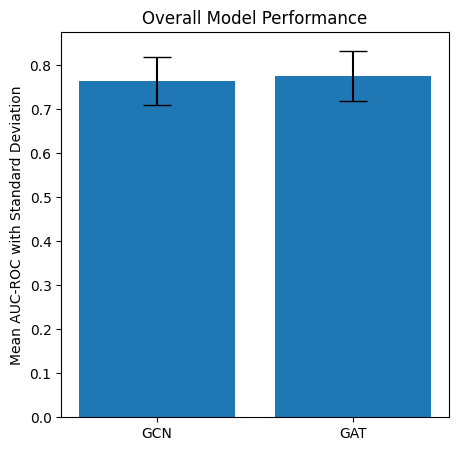

In [21]:
mean_gcn = roc_df['GCN AUC-ROC'].mean() 
std_gcn = roc_df['GCN AUC-ROC'].std()
mean_gat = roc_df['GAT AUC-ROC'].mean() 
std_gat = roc_df['GAT AUC-ROC'].std()

plt.figure(figsize=(5,5))
plt.bar(['GCN', 'GAT'], [mean_gcn, mean_gat], yerr=[std_gcn, std_gat], capsize=10)
plt.ylabel('Mean AUC-ROC with Standard Deviation')
plt.title('Overall Model Performance')
plt.show()

Disagreement Table for GCN and GAT

In [22]:
def get_model_probs(model, loader, device):
    model.eval()
    probs_list = []
    with torch.no_grad():
        for data in loader:
            data.x = data.x.to(torch.float)
            data.edge_index = data.edge_index.to(torch.long)
            if hasattr(data, "edge_attr") and data.edge_attr is not None:
                data.edge_attr = data.edge_attr.to(torch.float)
            data = data.to(device)
            logits = model(data.x, data.edge_index, data.batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            probs_list.append(probs)
    if len(probs_list)==0:
        return np.zeros((0,0))
    return np.vstack(probs_list)


gcn_probs = get_model_probs(gcn_model, test_loader, CONFIG['device'])
gat_probs = get_model_probs(gat_model, test_loader, CONFIG['device'])
print("gcn_probs.shape = ", gcn_probs.shape, "gat_probs.shape =", gat_probs.shape)

gcn_probs.shape =  (783, 12) gat_probs.shape = (783, 12)


In [23]:
def build_disagreement_table(smiles_list, labels, gcn_pred, gat_pred, task_names, threshold=0.5):
    rows = []
    labels_np = labels.cpu().numpy() if hasattr(labels, 'cpu') else labels

    for i in range(len(smiles_list)):
        y_true = labels_np[i]
        gcn_bin = (gcn_pred[i] >= threshold).astype(int)
        gat_bin = (gat_pred[i] >= threshold).astype(int)
        
        gcn_toxic = int(gcn_bin.sum() > 0)
        gat_toxic = int(gat_bin.sum() > 0)
        true_toxic = int(y_true.sum() > 0)

        if gcn_toxic == true_toxic and gat_toxic == true_toxic:
            who = "Both"
        elif gcn_toxic == true_toxic and gat_toxic != true_toxic:
            who = "GCN"
        elif gat_toxic == true_toxic and gcn_toxic != true_toxic:
            who = "GAT"
        else:
            who = "Neither"
        
        disagreements = [
            task_names[j] for j in range(len(task_names))
            if gcn_bin[j] != gat_bin[j]
        ]

        rows.append({
            "idx": i,
            "SMILES": smiles_list[i],
            "GCN_pred": float(gcn_pred[i].mean()),
            "GAT_pred": float(gat_pred[i].mean()),
            "abs_diff": float(np.abs(gcn_pred[i] - gat_pred[i]).mean()),
            "gcn_toxic": gcn_toxic,
            "gat_toxic": gat_toxic,
            "true_toxic": true_toxic,
            "correct_model": who,
            "disagreement_tasks": disagreements,
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("abs_diff", ascending=False).reset_index(drop=True)
    return df

In [24]:
labels = torch.vstack([data.y for data in test_dataset])
disagree_df = build_disagreement_table(
    data_test['smiles'],
    labels,
    gcn_probs,
    gat_probs,
    task_names,
    threshold=0.5
)
disagree_df.head(10)

,idx,SMILES,GCN_pred,GAT_pred,abs_diff,gcn_toxic,gat_toxic,true_toxic,correct_model,disagreement_tasks
0,1,CCCC[Sn](CCCC)(CCCC)CCCC,0.123440,0.440394,0.346041,0,1,0,GCN,"[NR-AR-LBD, NR-ER-LBD, NR-PPAR-gamma, SR-ARE, ..."
1,558,Cl[Hg]c1ccccc1,0.305124,0.457515,0.290603,0,1,0,GCN,"[NR-AR-LBD, NR-ER-LBD, NR-PPAR-gamma, SR-ARE, ..."
2,2,CCCC[Sn](Cl)(Cl)Cl,0.156087,0.358006,0.225995,0,1,0,GCN,"[SR-ARE, SR-HSE, SR-MMP]"
3,719,Oc1nc(O)nc(O)n1,0.093231,0.311587,0.218356,0,1,0,GCN,"[NR-AhR, NR-ER, SR-ARE, SR-MMP]"
4,621,CO[C@H]1C[C@H](O[C@@H]2[C@@H](C)C(=O)O[C@H](C)...,0.213501,0.032555,0.180946,1,0,0,GAT,"[NR-AR, NR-AR-LBD]"
5,316,N[C@H]1[C@@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4...,0.304281,0.129394,0.174887,0,0,0,Both,[]
6,185,NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H...,0.234501,0.059617,0.174884,1,0,0,GAT,"[NR-AR, NR-AR-LBD]"
7,26,COc1cc2c(cc1OC)[C@@]13CCN4CC5=CCO[C@H]6CC(=O)N...,0.222747,0.061477,0.161270,0,0,1,Neither,[]
8,253,[Hg+2],0.042911,0.202517,0.159606,0,0,0,Both,[]
9,628,CC(=O)O[C@H]1C[C@@H]2CC[C@@H]3[C@H](CC[C@@]4(C...,0.233813,0.083990,0.156917,1,0,0,GAT,"[NR-AR, NR-ER]"


# GAT Visualization

In [25]:
%pip install rdkit

Note: you may need to restart the kernel to use updated packages.


In [26]:
from rdkit.Chem import Draw
from rdkit import Chem

def atom_attention_scores(edge_index, attn, num_nodes):
    if attn.dim() == 2:
        attn = attn.mean(dim=1)

    scores = torch.zeros(num_nodes, dtype=torch.float)

    for (i, j), a in zip(edge_index.t(), attn):
        scores[i] += a
        scores[j] += a

    scores = scores / (scores.max() + 1e-8) # Normalize to [0, 1]
    return scores


def draw_attention(smiles, scores):
    mol = Chem.MolFromSmiles(smiles)
    atom_colors = {i: (0.0, 0.0, float(scores[i])) for i in range(len(scores))}

    return Draw.MolToImage(mol, highlightAtoms=list(atom_colors.keys()), highlightAtomColors=atom_colors, size=(350, 350))

Example using 1 molecule

/tmp/ipykernel_11652/3502556728.py:20: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  atom_colors = {i: (0.0, 0.0, float(scores[i])) for i in range(len(scores))}


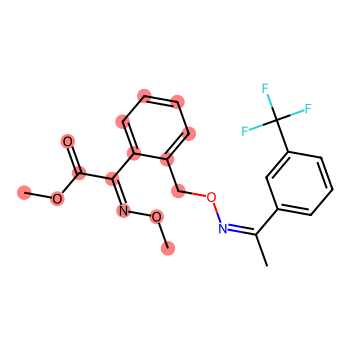

In [27]:
gat_model.eval()
data = test_dataset[0].to(CONFIG['device'])
logits, edge_index, attn = gat_model.forward_with_attention(data.x, data.edge_index, data.batch)
scores = atom_attention_scores(edge_index, attn, data.x.size(0))

img = draw_attention(data_test['smiles'][7], scores)
img

In [28]:
def visualize_topk_attention(model, dataset, smiles_list, k=9):
    model.eval()
    scores_list = []

    for i, data in enumerate(dataset):
        data = data.to(CONFIG['device'])
        with torch.no_grad():
            logits, edge_index, attn = model.forward_with_attention(data.x, data.edge_index, data.batch)
        scores = atom_attention_scores(edge_index, attn, data.x.size(0))
        scores_list.append((i, scores.mean().item())) # Mean attention score per molecule

    # Pick top-k molecules with highest mean attention scores
    topk_indices = [idx for idx, _ in sorted(scores_list, key=lambda x: x[1], reverse=True)[:k]]

    plt.figure(figsize=(12, 12))
    for j, idx in enumerate(topk_indices):
        data = dataset[idx].to(CONFIG['device'])
        logits, edge_index, attn = model.forward_with_attention(data.x, data.edge_index, data.batch)
        scores = atom_attention_scores(edge_index, attn, data.x.size(0))
        img = draw_attention(smiles_list[idx], scores)
        plt.subplot(int(np.ceil(k/3)), 3, j+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Molecule {idx}")
    plt.tight_layout()
    plt.show()

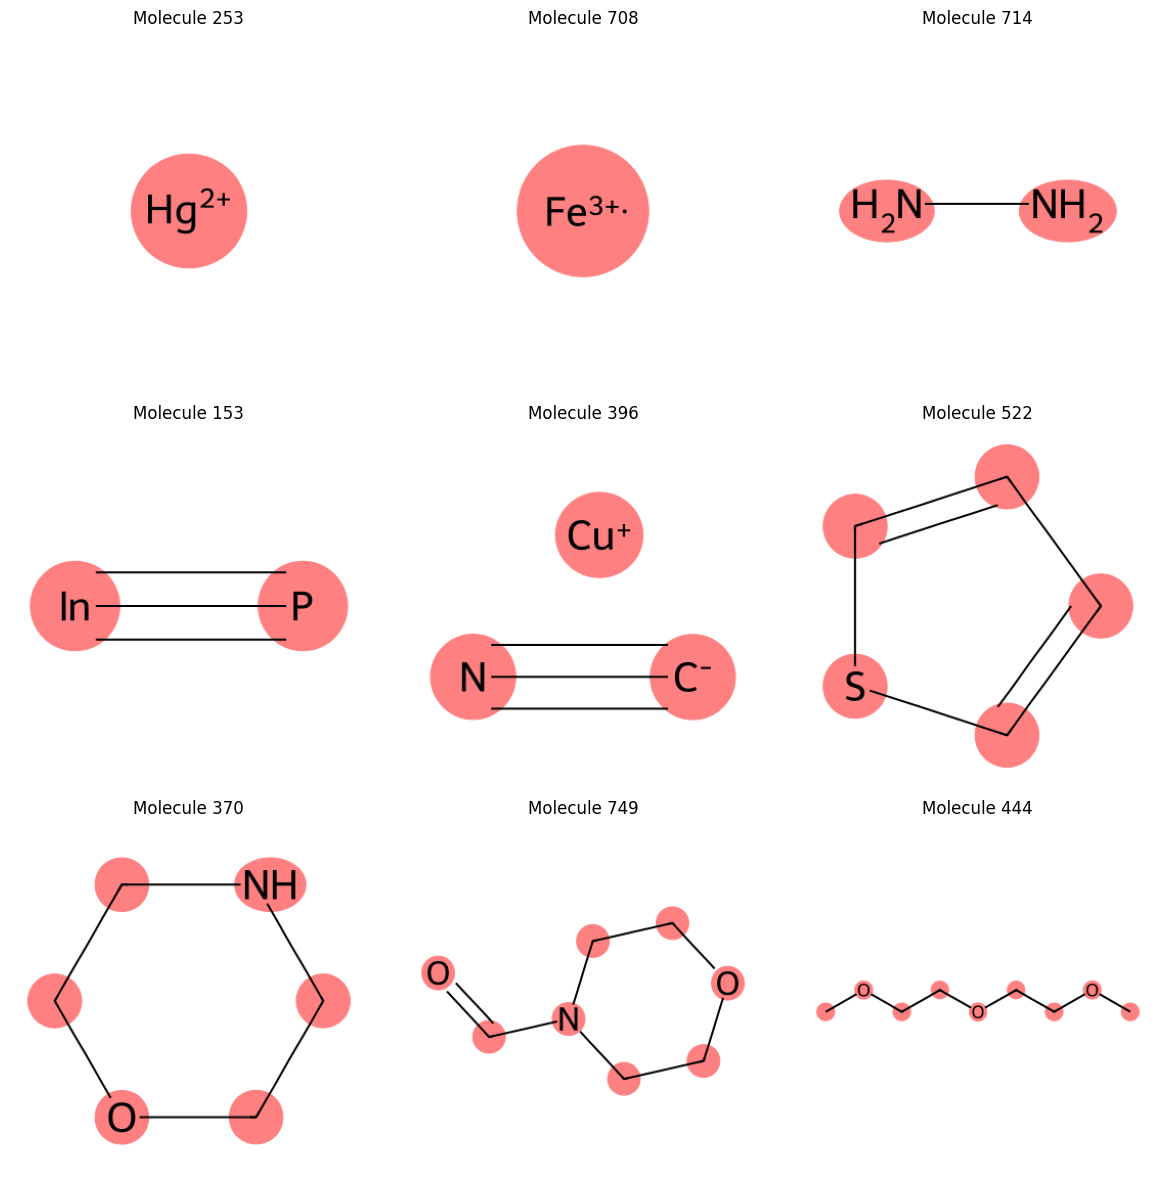

In [29]:
visualize_topk_attention(gat_model, test_dataset, data_test['smiles'], k=9)

Highlighting Functional Substructures (SMARTS Patterns)

In [30]:
TOXICOPHORE_SMARTS = {
    "Nitro group": "[N+](=O)[O-]",
    "Aromatic amine": "[NX3;H2,H1;!$(NC=O)]",
    "Halogen": "[F,Cl,Br,I]",
    "Hydroxyl": "[OX2H]",
    "Carboxylic acid": "C(=O)[OH]",
    "Ester": "C(=O)O",
    "Carbonyl": "[CX3]=O",
    "Amide": "C(=O)N",
    "Phenol": "c[OX2H]",
    "Aniline": "c[NX3H2,NX3H,NX3]"
}


def find_substructure_atoms(smiles, smarts_library):
    mol = Chem.MolFromSmiles(smiles)
    highlight_atoms = {}
    for name, smarts in smarts_library.items():
        patt = Chem.MolFromSmarts(smarts)
        if patt is None:
            continue
        matches = mol.GetSubstructMatches(patt)
        if matches:
            atom_ids = sorted({a for match in matches for a in match})
            highlight_atoms[name] = atom_ids
    return highlight_atoms

In [31]:
smil = data_test['smiles'][521]
highlight_atoms = find_substructure_atoms(smil, TOXICOPHORE_SMARTS)
print(highlight_atoms)

{'Ester': [12, 13, 14], 'Carbonyl': [5, 6, 12, 13]}


In [32]:
def draw_attention_with_substructures(smiles, atom_scores, substructures):
    mol = Chem.MolFromSmiles(smiles)
    atom_scores = atom_scores / (atom_scores.max() + 1e-6)

    # Normalize red intensity for atoms (attention)
    atom_scores = {i: (1.0, 1.0 - atom_scores[i], 1.0 - atom_scores[i]) for i in range(len(atom_scores))}

    # Highlight substructures with distinct colors
    palette = [
        (0.6, 0.8, 1.0),  # light blue
        (0.8, 1.0, 0.6),  # light green
        (1.0, 0.8, 0.4),  # light orange
        (0.9, 0.6, 1.0),  # light purple
    ]

    highlight_dict = {}
    for i, (name, atom_ids) in enumerate(substructures.items()):
        color = palette[i % len(palette)]
        for atom_id in atom_ids:
            highlight_dict[atom_id] = color
    
    drawer = Draw.MolDraw2DCairo(400, 300)
    Draw.rdMolDraw2D.PrepareAndDrawMolecule(
        drawer, mol,
        highlightAtoms=list(highlight_dict.keys()),
        highlightAtomColors=highlight_dict,
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

Draw Molecule 260 as a Test

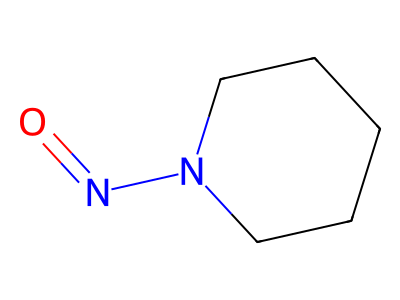

In [33]:
highlight_atoms = find_substructure_atoms(data_test['smiles'][260], TOXICOPHORE_SMARTS)
img_bytes = draw_attention_with_substructures(data_test['smiles'][260], scores, highlight_atoms)

from IPython.display import Image
Image(data=img_bytes)

Graph Representation of Molecule 260

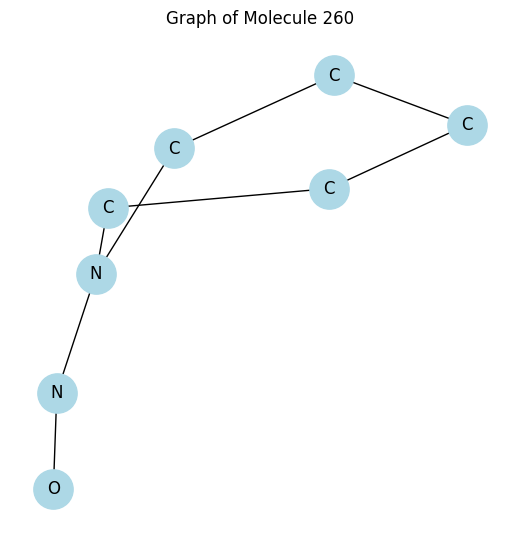

In [35]:
import networkx as nx

def draw_molecule_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    G = nx.Graph()

    # Nodes are atoms
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        symbol = atom.GetSymbol()
        G.add_node(idx, label=symbol)

    # Edges are bonds
    for bond in mol.GetBonds():
        a = bond.GetBeginAtomIdx()
        b = bond.GetEndAtomIdx()
        G.add_edge(a, b)

    pos = nx.spring_layout(G, seed=0)
    labels = nx.get_node_attributes(G, 'label')
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=800, node_color='lightblue', font_size=12)
    plt.title("Graph of Molecule 260")
    plt.show()


draw_molecule_graph(data_test['smiles'][260])

# GCN Saliency Calculations

In [36]:
def get_gcn_saliency(model, data, device):
    model.eval()
    data = data.to(device)
    x = data.x.clone().detach().float().to(device)
    x.requires_grad = True

    out = model(x, data.edge_index, data.batch)
    pred = out.sum()
    model.zero_grad()
    pred.backward()

    grads = x.grad.detach().cpu().numpy()
    saliency = np.sqrt((grads ** 2).sum(axis=1))
    return saliency

In [37]:
def draw_saliency_with_substructures(smiles, saliency, substructures):
    mol = Chem.MolFromSmiles(smiles)
    saliency = saliency.astype(float)
    saliency = saliency / (saliency.max() + 1e-6)

    atom_colours = {
        int(i): (1.0, float(1.0 - saliency[i]), float(1.0 - saliency[i]))
        for i in range(len(saliency))
    }

    palette = [
        (0.6, 0.8, 1.0),
        (0.8, 1.0, 0.6),
        (1.0, 0.8, 0.4),
        (0.9, 0.6, 1.0),
    ]

    highlight_dict = {}
    for j, (name, atom_ids) in enumerate(substructures.items()):
        colour = palette[j % len(palette)]
        for atom_id in atom_ids:
            highlight_dict[atom_id] = colour

    drawer = Draw.MolDraw2DCairo(400, 300)
    Draw.rdMolDraw2D.PrepareAndDrawMolecule(
        drawer, mol,
        highlightAtoms=list(highlight_dict.keys()) + list(atom_colours.keys()),
        highlightAtomColors={**atom_colours, **highlight_dict}
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

# Drawing the molecules that the GNN models disagree on the most

----------------------
Index: 1
SMILES: CCCC[Sn](CCCC)(CCCC)CCCC
GCN_pred: 0.123
GAT_pred: 0.440
abs_diff: 0.346
Correct model: GCN
Tasks disagreeing: ['NR-AR-LBD', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

GAT Attention:


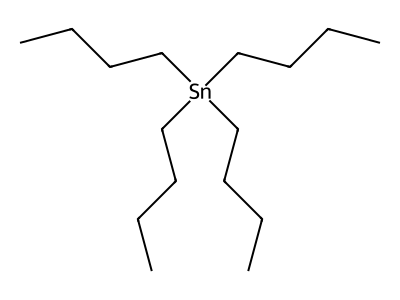

GCN Saliency:


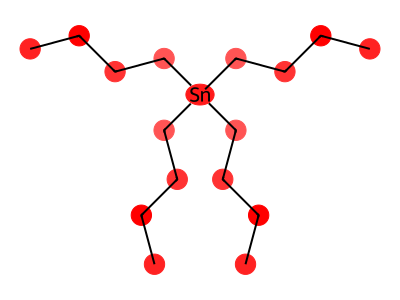

----------------------
Index: 558
SMILES: Cl[Hg]c1ccccc1
GCN_pred: 0.305
GAT_pred: 0.458
abs_diff: 0.291
Correct model: GCN
Tasks disagreeing: ['NR-AR-LBD', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

GAT Attention:


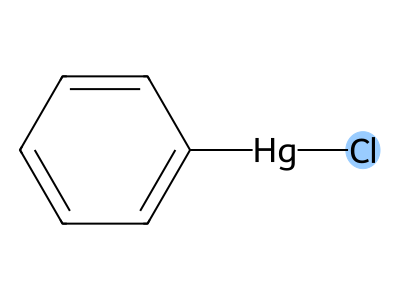

GCN Saliency:


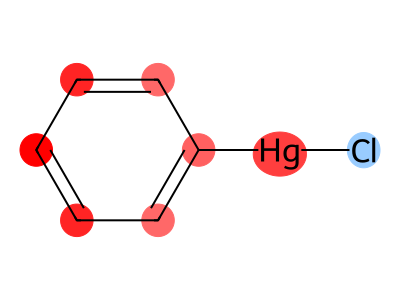

----------------------
Index: 2
SMILES: CCCC[Sn](Cl)(Cl)Cl
GCN_pred: 0.156
GAT_pred: 0.358
abs_diff: 0.226
Correct model: GCN
Tasks disagreeing: ['SR-ARE', 'SR-HSE', 'SR-MMP']

GAT Attention:


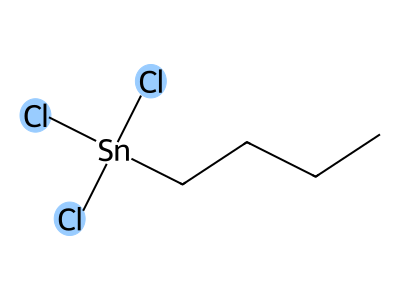

GCN Saliency:


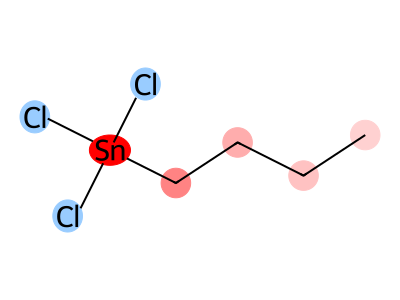

----------------------
Index: 719
SMILES: Oc1nc(O)nc(O)n1
GCN_pred: 0.093
GAT_pred: 0.312
abs_diff: 0.218
Correct model: GCN
Tasks disagreeing: ['NR-AhR', 'NR-ER', 'SR-ARE', 'SR-MMP']

GAT Attention:


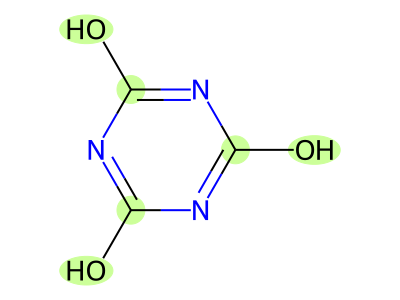

GCN Saliency:


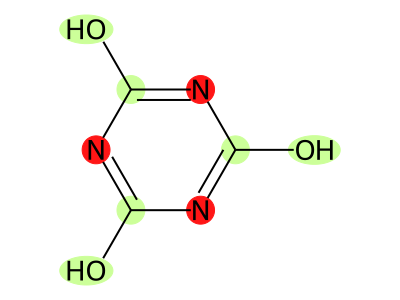

----------------------
Index: 621
SMILES: CO[C@H]1C[C@H](O[C@@H]2[C@@H](C)C(=O)O[C@H](C)[C@H](C)[C@H](OC(C)=O)[C@@H](C)C(=O)[C@@]3(CO3)C[C@H](C)[C@H](O[C@@H]3O[C@H](C)C[C@H](N(C)C)[C@H]3OC(C)=O)[C@H]2C)O[C@@H](C)[C@@H]1OC(C)=O
GCN_pred: 0.214
GAT_pred: 0.033
abs_diff: 0.181
Correct model: GAT
Tasks disagreeing: ['NR-AR', 'NR-AR-LBD']

GAT Attention:


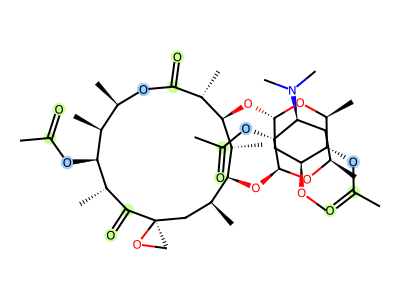

GCN Saliency:


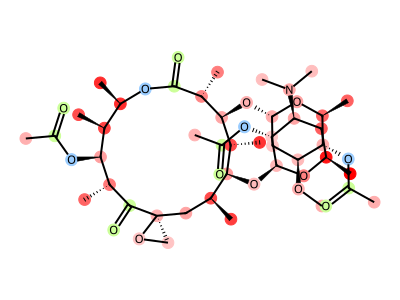

----------------------
Index: 316
SMILES: N[C@H]1[C@@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)C[C@H]12
GCN_pred: 0.304
GAT_pred: 0.129
abs_diff: 0.175
Correct model: Both
Tasks disagreeing: []

GAT Attention:


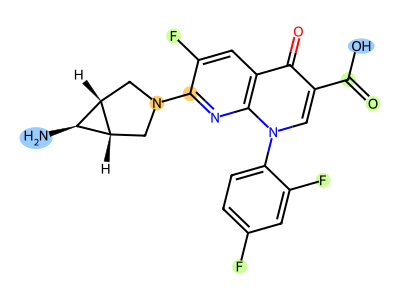

GCN Saliency:


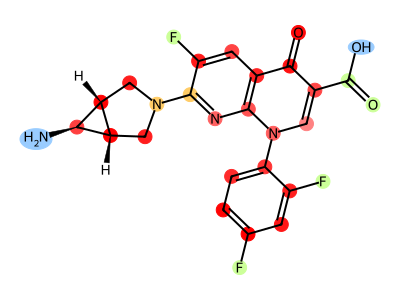

----------------------
Index: 185
SMILES: NC[C@H]1O[C@H](O[C@@H]2[C@@H](N)C[C@@H](N)[C@H](O[C@H]3O[C@H](CO)[C@@H](O)[C@H](N)[C@H]3O)[C@H]2O)[C@H](N)C[C@@H]1O
GCN_pred: 0.235
GAT_pred: 0.060
abs_diff: 0.175
Correct model: GAT
Tasks disagreeing: ['NR-AR', 'NR-AR-LBD']

GAT Attention:


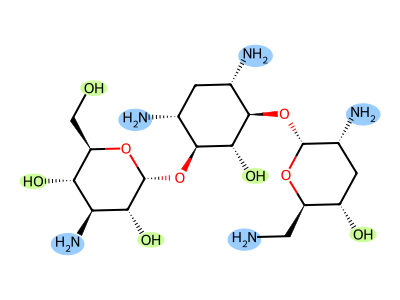

GCN Saliency:


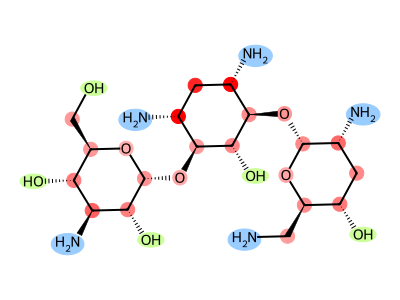

----------------------
Index: 26
SMILES: COc1cc2c(cc1OC)[C@@]13CCN4CC5=CCO[C@H]6CC(=O)N2[C@H]1[C@H]6[C@H]5C[C@H]43
GCN_pred: 0.223
GAT_pred: 0.061
abs_diff: 0.161
Correct model: Neither
Tasks disagreeing: []

GAT Attention:


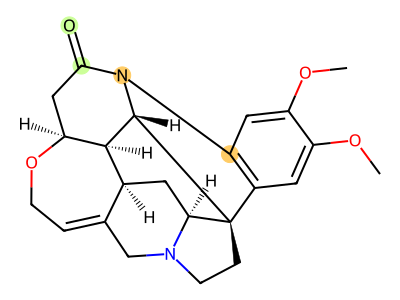

GCN Saliency:


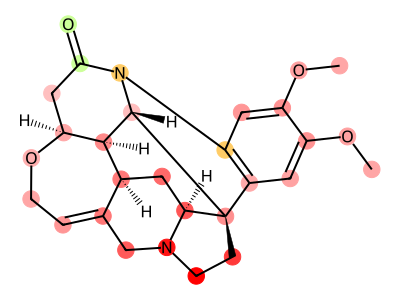

----------------------
Index: 253
SMILES: [Hg+2]
GCN_pred: 0.043
GAT_pred: 0.203
abs_diff: 0.160
Correct model: Both
Tasks disagreeing: []

GAT Attention:


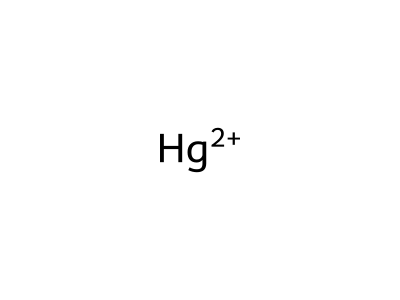

GCN Saliency:


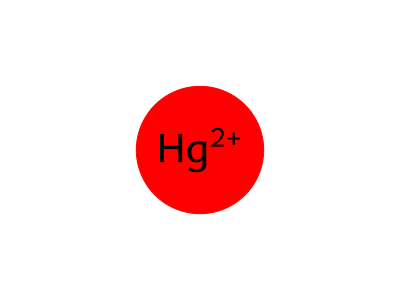

----------------------
Index: 628
SMILES: CC(=O)O[C@H]1C[C@@H]2CC[C@@H]3[C@H](CC[C@@]4(C)[C@H]3C[C@H]([N+]3(C)CCCCC3)[C@@H]4OC(C)=O)[C@@]2(C)C[C@@H]1[N+]1(C)CCCCC1
GCN_pred: 0.234
GAT_pred: 0.084
abs_diff: 0.157
Correct model: GAT
Tasks disagreeing: ['NR-AR', 'NR-ER']

GAT Attention:


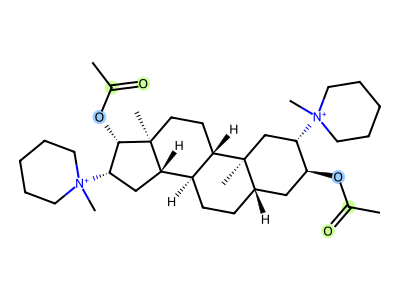

GCN Saliency:


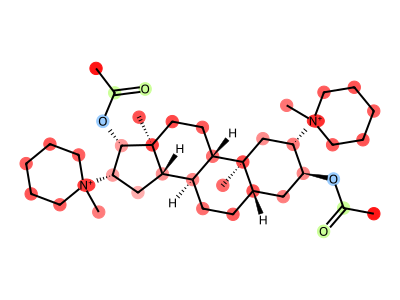

In [38]:
top10 = disagree_df.head(10)

for i, row in top10.iterrows():
    smi = row["SMILES"]
    idx = row["idx"]

    gcn_data = test_dataset[idx]

    subs = find_substructure_atoms(smi, TOXICOPHORE_SMARTS)
    png_gat = draw_attention_with_substructures(smi, scores, subs)

    saliency = get_gcn_saliency(gcn_model, gcn_data, CONFIG["device"])
    png_gcn = draw_saliency_with_substructures(smi, saliency, subs)

    print(f"----------------------")
    print(f"Index: {row['idx']}")
    print(f"SMILES: {smi}")
    print(f"GCN_pred: {row['GCN_pred']:.3f}")
    print(f"GAT_pred: {row['GAT_pred']:.3f}")
    print(f"abs_diff: {row['abs_diff']:.3f}")
    print(f"Correct model: {row['correct_model']}")
    print(f"Tasks disagreeing: {row['disagreement_tasks']}")

    print("\nGAT Attention:")
    display(Image(data=png_gat))

    print("GCN Saliency:")
    display(Image(data=png_gcn))


# Biological Meaning Analysis

In [39]:
%pip install scipy seaborn
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [40]:
from scipy.stats import fisher_exact
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm
import math

def find_substructure_atoms(smiles, smarts_library):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {}
    highlight_atoms = {}
    for name, smarts in smarts_library.items():
        patt = Chem.MolFromSmarts(smarts)
        if patt is None:
            continue
        matches = mol.GetSubstructMatches(patt)
        if matches:
            atom_ids = sorted({a for match in matches for a in match})
            highlight_atoms[name] = atom_ids
    return highlight_atoms


def atom_attention_scores(edge_index, attn, num_nodes):
    # Average across heads if needed
    if attn.dim() == 2:
        attn = attn.mean(dim=1)

    scores = torch.zeros(num_nodes, dtype=torch.float)

    # IMPORTANT: detach before converting to numpy or indexing loops
    ei = edge_index.t().detach().cpu().numpy()
    attn_vals = attn.detach().cpu().numpy()

    for (i, j), a in zip(ei, attn_vals):
        scores[i] += a
        scores[j] += a

    # Normalize
    if scores.max() > 0:
        scores = scores / (scores.max() + 1e-8)

    return scores



def find_substructure_atoms(smiles, smarts_dict):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {}
    matches = {}
    for name, smarts in smarts_dict.items():
        patt = Chem.MolFromSmarts(smarts)
        if patt is None:
            continue
        sub_matches = mol.GetSubstructMatches(patt)
        if sub_matches:
            atom_ids = sorted({a for m in sub_matches for a in m})
            matches[name] = atom_ids
    return matches


def draw_attention(smiles, atom_scores, highlight_atoms=None, figsize=(300, 240)):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    atom_colors = {}
    # Map attention scores to red intensity
    for i, s in enumerate(atom_scores.tolist()):
        atom_colors[i] = (1.0, 1.0 - float(s), 1.0 - float(s))

    # Substructures highlighted by unique colour
    highlight_atom_list = []
    highlight_dict = {}
    if highlight_atoms:
        palette = [
            (0.6, 0.85, 1.0), # Blue
            (0.7, 1.0, 0.7), # Green
            (1.0, 0.85, 0.6), # Orange
            (1.0, 0.7, 0.9), # Pink
            (0.9, 0.9, 0.6), # Yellow
            (0.8, 0.7, 1.0), # Violet
        ]
        for idx, (name, atoms) in enumerate(highlight_atoms.items()):
            for a in atoms:
                highlight_dict[a] = palette[idx % len(palette)]
        highlight_atom_list = list(highlight_dict.keys())

    drawer = Draw.MolDraw2DCairo(figsize[0], figsize[1])
    opts = drawer.drawOptions()
    # Draw both attention and SMARTS
    Draw.rdMolDraw2D.PrepareAndDrawMolecule(
        drawer, mol,
        highlightAtoms=list(set(list(atom_colors.keys()) + highlight_atom_list)),
        highlightAtomColors={**atom_colors, **highlight_dict}
    )
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    return png

Per-Molecule Substructure Presence

In [41]:
def compute_substructure_attention_stats(model, dataset, smiles_list, smarts_dict, device):
    model.eval()
    per_rows = []
    skipped = 0
    total = len(dataset)

    for idx, (data, smi) in enumerate(tqdm(zip(dataset, smiles_list), total=len(dataset))):
        if data is None:
            skipped += 1
            per_rows.append({
                'idx': idx, 'smiles': smi,
                'mean_attention': np.nan, 'max_attention': np.nan,
                'atom_scores': None, 'matched_smarts': []
            })
            continue

        try:
            data = data.to(device)
            out, attn_edge_index, attn_values = model.forward_with_attention(data.x, data.edge_index, data.batch)
        except Exception as e:
            skipped += 1
            per_rows.append({
                'idx': idx, 'smiles': smi,
                'mean_attention': np.nan, 'max_attention': np.nan,
                'atom_scores': None, 'matched_smarts': []
            })
            continue

        num_nodes = data.x.size(0)
        atom_scores = atom_attention_scores(attn_edge_index, attn_values, num_nodes)
        mean_att = float(atom_scores.mean().item())
        max_att = float(atom_scores.max().item())

        matched = list(find_substructure_atoms(smi, smarts_dict).keys())

        per_rows.append({
            'idx': idx,
            'smiles': smi,
            'mean_attention': mean_att,
            'max_attention': max_att,
            'atom_scores': atom_scores.numpy().tolist(),
            'matched_smarts': matched
        })

    per_molecule_df = pd.DataFrame(per_rows)

    stats_rows = []
    N = len(per_molecule_df)
    for name in smarts_dict.keys():
        hits = per_molecule_df[per_molecule_df['matched_smarts'].apply(lambda L: name in L)]
        n_mols = len(hits)
        if n_mols > 0:
            mean_atom_attention = float(np.nanmean(hits['mean_attention']))
            mean_max_attention = float(np.nanmean(hits['max_attention']))
            molecule_indices = hits['idx'].tolist()
        else:
            mean_atom_attention = np.nan
            mean_max_attention = np.nan
            molecule_indices = []

        stats_rows.append({
            'SMARTS': name,
            'n_molecules': n_mols,
            'mean_atom_attention': mean_atom_attention,
            'mean_max_attention': mean_max_attention,
            'molecule_indices': molecule_indices
        })
    
    stats_df = pd.DataFrame(stats_rows)
    print(f"Computed stats: {len(per_rows)} molecules processed, skipped {skipped} entries.")
    return per_molecule_df, stats_df

Enrichment Test to see if SMARTS have higher chances of being toxic

In [42]:
def compute_enrichment(stats_df, per_molecule_df, fractions=[0.01, 0.05, 0.1, 0.2]):
    # enrichment = (fraction of top group containing SMARTS) / (fraction in background)
    N = len(per_molecule_df)
    smarts_names = stats_df['SMARTS'].tolist()
    incidence = {}
    for s in smarts_names:
        incidence[s] = stats_df.loc[stats_df['SMARTS']==s, 'n_molecules'].values[0] / max(N,1)

    sorted_mols = per_molecule_df.sort_values('mean_attention', ascending=False).reset_index(drop=True)

    enrich_rows = []
    for s in smarts_names:
        row = {'SMARTS': s, 'background_frac': incidence[s]}
        for f in fractions:
            k = max(1, int(np.ceil(f * N)))
            topk = sorted_mols.head(k)
            top_frac = topk['matched_smarts'].apply(lambda L: s in L).sum() / max(k,1)
            if incidence[s] > 0:
                enrichment = top_frac / incidence[s]
            else:
                enrichment = np.nan
            row[f"top_{int(f*100)}pct_frac"] = top_frac
            row[f"enrichment_{int(f*100)}pct"] = enrichment
        enrich_rows.append(row)
    enrich_df = pd.DataFrame(enrich_rows).sort_values('enrichment_5pct', ascending=False)
    return enrich_df


def plot_enrichment_heatmaps(enrich_df, fractions=[1,5,10,20], top_n=10):
    # rows = SMARTS, cols = fractions
    cols = [f"enrichment_{t}pct" for t in fractions]
    enrich_df = enrich_df.copy().reset_index(drop=True)
    top = enrich_df.head(top_n)
    heat_data = top[cols].replace([np.inf, -np.inf], np.nan).fillna(0).astype(float)
    plt.figure(figsize=(len(cols)*1.8, top_n*0.5 + 2))
    sns.heatmap(heat_data, annot=True, fmt=".2f", yticklabels=top['SMARTS'], cmap="vlag", center=1.0)
    plt.title("Enrichment of SMARTS in top-attention molecules")
    plt.xlabel("Fraction (pct)")
    plt.show()

In [43]:
def enrichment_with_overlap_all(per_molecule_df, top_fraction=0.20):
    # Compute overlap of all SMARTS in the top x% high-attention molecules
    df = per_molecule_df.copy()
    df['matched_smarts'] = df['matched_smarts'].apply(lambda x: x if isinstance(x, list) else [])
    N = len(df)
    k = max(1, int(np.ceil(top_fraction * N)))

    df_sorted = df.sort_values('mean_attention', ascending=False).reset_index(drop=True)
    topk = df_sorted.head(k)
    all_smarts = sorted({s for sublist in df['matched_smarts'] for s in (sublist if isinstance(sublist, list) else [])})
    results = []

    for sm in all_smarts:
        background_count = df['matched_smarts'].apply(lambda L: sm in L).sum()
        top_count = topk['matched_smarts'].apply(lambda L: sm in L).sum()
        overlap_frac = top_count / k if k > 0 else 0
        results.append({
            "SMARTS": sm,
            "background_count": background_count,
            "topk_count": top_count,
            "overlap_fraction": overlap_frac
        })
    
    return pd.DataFrame(results).sort_values('overlap_fraction', ascending=False)

In [44]:
per_molecule_df, stats_df = compute_substructure_attention_stats(gat_model, test_dataset, data_test['smiles'], TOXICOPHORE_SMARTS, CONFIG['device'])
display(per_molecule_df.head())
display(stats_df.head())

100%|██████████| 783/783 [00:06<00:00, 123.59it/s]

Computed stats: 783 molecules processed, skipped 0 entries.


,idx,smiles,mean_attention,max_attention,atom_scores,matched_smarts
0,0,O=C(O)c1ccc(S(=O)(=O)N(Cl)Cl)cc1,0.433934,1.0,"[0.34080925583839417, 0.5779308676719666, 0.32...","[Halogen, Hydroxyl, Carboxylic acid, Ester, Ca..."
1,1,CCCC[Sn](CCCC)(CCCC)CCCC,0.574143,1.0,"[0.5096728801727295, 0.6403754949569702, 0.548...",[]
2,2,CCCC[Sn](Cl)(Cl)Cl,0.514589,1.0,"[0.4568063020706177, 0.5739516019821167, 0.492...",[Halogen]
3,3,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,0.635338,1.0,"[0.478622168302536, 0.6622704267501831, 0.8439...",[Hydroxyl]
4,4,CCN(CC)CCC(=O)N1c2ccccc2Sc2ccc(Cl)cc21,0.693697,1.0,"[0.6305466890335083, 0.7257373929023743, 0.776...","[Halogen, Carbonyl, Amide, Aniline]"


,SMARTS,n_molecules,mean_atom_attention,mean_max_attention,molecule_indices
0,Nitro group,35,0.632296,1.0,"[24, 42, 45, 51, 53, 90, 103, 194, 200, 219, 2..."
1,Aromatic amine,149,0.595975,1.0,"[6, 11, 18, 43, 44, 60, 64, 72, 76, 78, 83, 84..."
2,Halogen,197,0.607442,1.0,"[0, 2, 4, 7, 28, 30, 33, 41, 48, 56, 67, 68, 7..."
3,Hydroxyl,303,0.590703,1.0,"[0, 3, 5, 8, 10, 14, 16, 17, 21, 22, 28, 32, 3..."
4,Carboxylic acid,87,0.609779,1.0,"[0, 5, 22, 43, 48, 61, 65, 67, 71, 73, 78, 80,..."


In [45]:
enrich_df = compute_enrichment(stats_df, per_molecule_df, fractions=[0.01, 0.05, 0.1, 0.2])
display(enrich_df.head(30))

,SMARTS,background_frac,top_1pct_frac,enrichment_1pct,top_5pct_frac,enrichment_5pct,top_10pct_frac,enrichment_10pct,top_20pct_frac,enrichment_20pct
2,Halogen,0.251596,0.000,0.000000,0.125,0.496827,0.139241,0.553428,0.159236,0.632901
1,Aromatic amine,0.190294,0.250,1.313758,0.075,0.394128,0.088608,0.465636,0.089172,0.468602
6,Carbonyl,0.513410,0.125,0.243470,0.075,0.146082,0.265823,0.517759,0.426752,0.831210
7,Amide,0.185185,0.125,0.675000,0.025,0.135000,0.063291,0.341772,0.108280,0.584713
3,Hydroxyl,0.386973,0.000,0.000000,0.050,0.129208,0.101266,0.261687,0.178344,0.460869
0,Nitro group,0.044700,0.000,0.000000,0.000,0.000000,0.012658,0.283183,0.012739,0.284986
5,Ester,0.300128,0.000,0.000000,0.000,0.000000,0.126582,0.421761,0.248408,0.827673
4,Carboxylic acid,0.111111,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.082803,0.745223
8,Phenol,0.113665,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.012739,0.112073
9,Aniline,0.238825,0.000,0.000000,0.000,0.000000,0.025316,0.106004,0.089172,0.373378


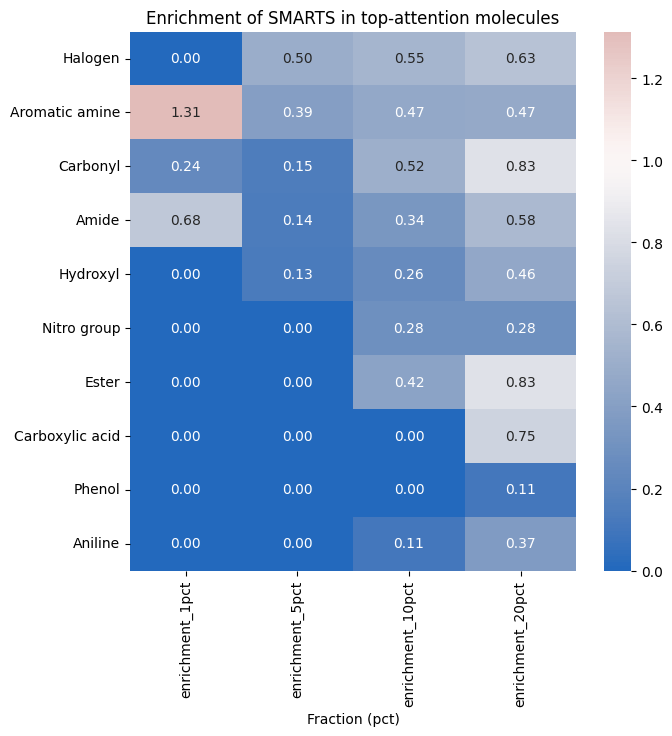

In [46]:
plot_enrichment_heatmaps(enrich_df, fractions=[1,5,10,20], top_n=10)

In [47]:
overlap_df = enrichment_with_overlap_all(per_molecule_df, top_fraction=0.20)
display(overlap_df)

,SMARTS,background_count,topk_count,overlap_fraction
3,Carbonyl,402,67,0.426752
5,Ester,235,39,0.248408
7,Hydroxyl,303,28,0.178344
6,Halogen,197,25,0.159236
0,Amide,145,17,0.108280
1,Aniline,187,14,0.089172
2,Aromatic amine,149,14,0.089172
4,Carboxylic acid,87,13,0.082803
8,Nitro group,35,2,0.012739
9,Phenol,89,2,0.012739
